## Lueders et al., 2004 (barkeri & extorquens)
 
* strain(s)
  * Methylobacterium extorquens AM1 DSM 1338
    * genome G+C = 68.7
  * M. barkeri DSM 800
    * *aka* Methanosarcina barkeri MS
    * genome G+C = 39.2
* isotope(s)
  * <sup>13</sup>C
  * assumed 100% incorporation
* gradient
  * rotor
    * TV865 vertical rotor (Sorvall)
      * vertical rotor
  * CsCl density
    * 1.725 g/ml
  * centrifugation 
    * 20<sup>o</sup>C
    * \>36h 
    * 45,000 r.p.m. (177,000 gav)
  * fractionation volume
    * 400 ul

* DNA quantification
  * both qPCR & fluorometrically
  * qPCR primers
    * Ar109f/Ar915r (Lueders and Friedrich, 2003) 
      * Ar109f (ACKGCTCAGTAACACGT)
      * Ar915r (GTGCTCCCCCGCCAATTCCT)
    * Ba519f/Ba907 (Stubner, 2002)
      * Ba519f (CAGCMGCCGCGGTAANWC)
      * Ba907r (CCGTCAATTCMTTTRAGTT)

# Setting variables

In [12]:
workDir = '/home/nick/notebook/SIPSim/dev/Leuders2004/'

lueders_fig1 = 'Lueders2004_Fig1.xls'

# params
bandwidth = 0.8

# Init

In [13]:
import os
import dill
import numpy as np
%load_ext rpy2.ipython
%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The pushnote extension is already loaded. To reload it, use:
  %reload_ext pushnote


In [14]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(genomes)
library(gridExtra)

In [15]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir

/home/nick/notebook/SIPSim/dev/Leuders2004


# Getting genomes

In [5]:
%%R
data(proks)
summary(proks)

$`Total genomes`
[1] 27570 genome projects on Sep 04, 2014

$`By status`
                     Total
Contig               13074
Scaffold             10718
Gapless Chromosome    3053
Chromosome             373
Chromosome with gaps   343
Complete                 9

$`Recent submissions`
  released   name                      status  
1 2014-09-02 Altuibacter lentus        Scaffold
2 2014-09-02 Bacillus cereus ATCC 4342 Scaffold
3 2014-09-02 Bacillus licheniformis    Scaffold
4 2014-09-02 Bacillus megaterium       Scaffold
5 2014-09-02 Paenibacillus macerans    Scaffold



In [6]:
%%R
update(proks)
summary(proks)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: proks has been successfully updated

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 33548 new project IDs added

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 246 old project IDs removed

  res = super(Function, self).__call__(*new_args, **new_kwargs)


$`Total genomes`
[1] 61484 genome projects on Mar 11, 2016

$`By status`
                Total
Contig          28292
Scaffold        27266
Complete Genome  5039
Chromosome        887

$`Recent submissions`
  released   name                         status  
1 2016-03-04 Akkermansia sp. KLE1798      Scaffold
2 2016-03-04 Escherichia coli             Contig  
3 2016-03-03 Bacillus cereus              Scaffold
4 2016-03-03 Bacteroides cellulosilyticus Scaffold
5 2016-03-03 Bacteroides fragilis         Scaffold



In [ ]:
%%R
M.ext = subset(proks, name %like% 'Methylobacterium extorquens AM1*')
M.bark = subset(proks, name %like% 'Methanosarcina barkeri MS*')
orgs = rbind(M.ext, M.bark)


orgFile = 'genome_info.txt'
write.table(orgs, orgFile, sep='\t', quote=FALSE, row.names=FALSE)
cat('File written:', orgFile, '\n')

In [ ]:
!seqDB_tools accession-GI2fasta \
        -a 11 -n 2 -f 30 -header \
        -o genomes \
        genome_info.txt 

In [ ]:
!ls -thlc genomes/*.fna

## renaming genome sequences

In [ ]:
!find ./genomes/ -name "*.fna" |\
    xargs -P 2 -I % SIPSim genome_rename --prefix genomes_rn %

## Indexing genomes

In [ ]:
# making a genome index file
## taxonName<tab>genomeSeqFileName
!ls -1 genomes_rn/*fna | perl -pe 's/.+\/|\.fna//g; s/(.+)/$1\t$1.fna/' > genome_index.txt
!cat genome_index.txt

In [ ]:
!SIPSim genome_index \
    --fp ./genomes_rn/ \
    --np 2 \
    genome_index.txt \
    > genome_index.log
    
!tail genome_index.log    

# Simulating a gradient community

In [8]:
comm = """library	taxon_name	rel_abund_perc	rank
1	Methanosarcina_barkeri_MS	100.0	1
1	Methylobacterium_extorquens_AM1	0.0	2
2	Methylobacterium_extorquens_AM1	100.0	1
2	Methanosarcina_barkeri_MS	0.0	2
"""

comm_file = 'comm-n2-unif.txt'
with open(comm_file, 'wb') as oFH:
    oFH.write(comm)
    
!cat $comm_file

library	taxon_name	rel_abund_perc	rank
1	Methanosarcina_barkeri_MS	100.0	1
1	Methylobacterium_extorquens_AM1	0.0	2
2	Methylobacterium_extorquens_AM1	100.0	1
2	Methanosarcina_barkeri_MS	0.0	2


# Simulating gradient fractions

In [117]:
!SIPSim gradient_fractions \
    --BD_min 1.66 \
    --BD_max 1.8 \
    --params mu:0.0075,sigma:0.001 \
    comm-n2-unif.txt \
    > fracs-n2-unif.txt

!wc -l fracs-n2-unif.txt
!head -n 5 fracs-n2-unif.txt
!tail -n 5 fracs-n2-unif.txt

39 fracs-n2-unif.txt
library	fraction	BD_min	BD_max	fraction_size
1	1	1.66	1.662	0.002
1	2	1.662	1.668	0.006
1	3	1.668	1.676	0.008
1	4	1.676	1.684	0.008
2	15	1.76	1.767	0.007
2	16	1.767	1.777	0.01
2	17	1.777	1.785	0.008
2	18	1.785	1.792	0.007
2	19	1.792	1.8	0.008


Source: local data frame [2 x 2]

  library     n
    (int) (int)
1       1    19
2       2    19


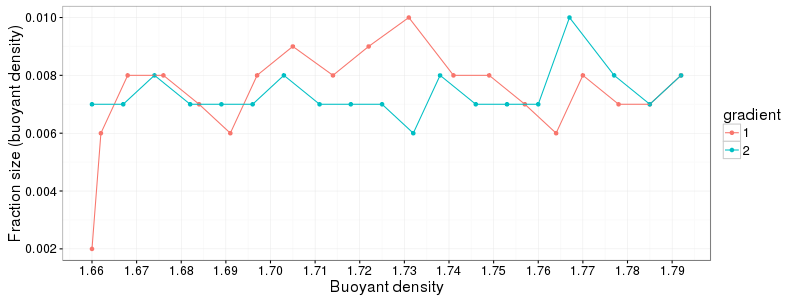

In [118]:
%%R -w 800 -h 300
# plotting
df = read.delim('fracs-n2-unif.txt', sep='\t')

df %>%
    group_by(library) %>%
    summarize(n=n()) %>%
    print

ggplot(df, aes(BD_min, fraction_size, group=library, color=library %>% as.character)) +
    geom_point() +
    geom_line() +
    scale_x_continuous(breaks=seq(1.66, 1.8, 0.01)) +
    scale_color_discrete('gradient') +
    labs(x='Buoyant density', y='Fraction size (buoyant density)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

# SIPSim of shotgun fragments

* for comparing to fluormetric quanitification

In [32]:
!SIPSim fragments \
    genome_index.txt \
    --fp genomes \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 100X \
    --np 2 \
    2> shotFrag_skewN90-25-n5-nS.log \
    > shotFrag_skewN90-25-n5-nS.pkl
    
!tail shotFrag_skewN90-25-n5-nS.log

Processing: "Methanosarcina_barkeri_MS"
Processing: "Methylobacterium_extorquens_AM1"
  Genome name: Methanosarcina_barkeri_MS
  Genome length (bp): 4533209
  Number of amplicons: None
  Number of fragments simulated: 64391
  Genome name: Methylobacterium_extorquens_AM1
  Genome length (bp): 5511322
  Number of amplicons: None
  Number of fragments simulated: 78333


## Converting to 2d-kde objects

* Also converts fragment G+C to buoyant density

In [665]:
!SIPSim fragment_KDE \
    shotFrag_skewN90-25-n5-nS.pkl \
    --bw $bandwidth \
    > shotFrag_skewN90-25-n5-nS_kde.pkl

!ls -thlc shotFrag_skewN90-25-n5-nS_kde.pkl

-rw-rw-r-- 1 nick nick 2.2M Mar 18 09:10 shotFrag_skewN90-25-n5-nS_kde.pkl


In [666]:
!SIPSim KDE_info -s shotFrag_skewN90-25-n5-nS_kde.pkl

Loading KDEs...
lib_ID	taxon_ID	KDE_ID	min	percentile_5	percentile_25	mean	median	percentile_75	percentile_95	max	stdev
1	Methylobacterium_extorquens_AM1	1	1.70360132092	1.72327819773	1.7262761602	1.7273283076	1.72761013386	1.728742901	1.73056126207	1.73686173295	0.00241770602417
1	Methylobacterium_extorquens_AM1	2	256.0	4108.0	6109.0	7035.78267142	7301.0	8207.0	9082.0	10740.0	1554.11137688
1	Methanosarcina_barkeri_MS	1	1.68548	1.69394847098	1.69668418292	1.69842993195	1.69846092781	1.7001455066	1.70284808197	1.712675	0.00272249367404
1	Methanosarcina_barkeri_MS	2	124.0	4114.5	6118.0	7040.14853007	7308.0	8214.0	9080.0	10740.0	1551.18266968


### Plotting distributions

In [667]:
n=100000
!SIPSim KDE_sample -n $n shotFrag_skewN90-25-n5-nS_kde.pkl > shotFrag_skewN90-25-n5-nS_kde.txt

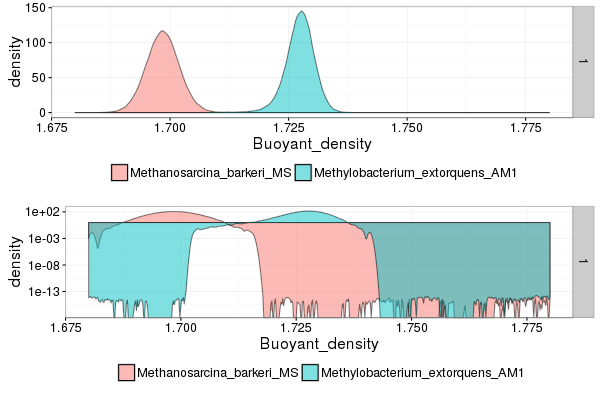

In [668]:
%%R -w 600 -h 400
df = read.delim('shotFrag_skewN90-25-n5-nS_kde.txt', sep='\t') %>%
    gather(taxon, Buoyant_density, Methanosarcina_barkeri_MS, Methylobacterium_extorquens_AM1) 


p = ggplot(df, aes(Buoyant_density, fill=taxon)) +
    geom_density(alpha=0.5) +
    scale_x_continuous(limits=c(1.68, 1.78)) +
    scale_fill_discrete('') +
    facet_grid(libID ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )
pl = p + scale_y_log10()

grid.arrange(p, pl, ncol=1)

## Adding diffusion

In [669]:
!SIPSim diffusion \
    shotFrag_skewN90-25-n5-nS_kde.pkl \
    --np 2 \
    --bw $bandwidth \
    > shotFrag_skewN90-25-n5-nS_dif_kde.pkl
    
!ls -thlc shotFrag_skewN90-25-n5-nS_dif_kde.pkl

Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS
-rw-rw-r-- 1 nick nick 7.7M Mar 18 09:10 shotFrag_skewN90-25-n5-nS_dif_kde.pkl


### Plotting distributions

In [670]:
n=100000
!SIPSim KDE_sample -n $n shotFrag_skewN90-25-n5-nS_dif_kde.pkl > shotFrag_skewN90-25-n5-nS_dif_kde.txt

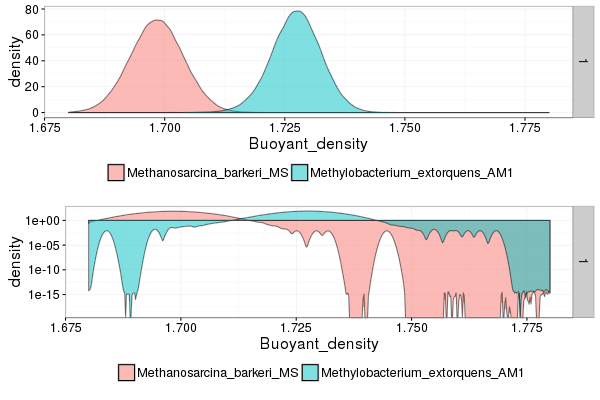

In [671]:
%%R -w 600 -h 400
df = read.delim('shotFrag_skewN90-25-n5-nS_dif_kde.txt', sep='\t') %>%
    gather(taxon, Buoyant_density, Methanosarcina_barkeri_MS, Methylobacterium_extorquens_AM1) 


p = ggplot(df, aes(Buoyant_density, fill=taxon)) +
    geom_density(alpha=0.5) +
    scale_x_continuous(limits=c(1.68, 1.78)) +
    scale_fill_discrete('') +
    facet_grid(libID ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )
pl = p + scale_y_log10()

grid.arrange(p, pl, ncol=1)

## Adding DBL smearing

In [672]:
!SIPSim DBL \
    shotFrag_skewN90-25-n5-nS_dif_kde.pkl \
    --comm comm-n2-unif.txt \
    --commx 0 \
    -D 1.725 \
    -w 19807714 \
    --tube_height 5.1 \
    --r_min 7.47 \
    --r_max 8.79 \
    --vertical \
    --np 2 \
    > shotFrag_skewN90-25-n5-nS_dif_kde_DBL.pkl

DBL_index file written: "DBL_index.txt"
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS


### Plotting smearing index

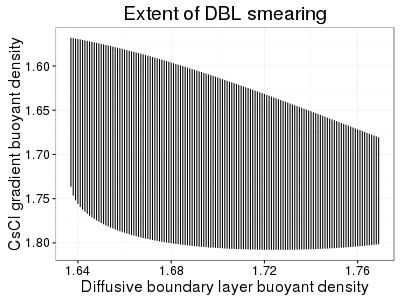

In [673]:
%%R -h 300 -w 400
df = read.delim('DBL_index.txt', sep='\t')

ggplot(df, aes(DBL_BD, ymin=vert_gradient_BD_low, ymax=vert_gradient_BD_high)) +
    geom_linerange() +
    scale_y_reverse() +
    labs(x='Diffusive boundary layer buoyant density', 
         y='CsCl gradient buoyant density',
         title='Extent of DBL smearing') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Plotting distributions

In [674]:
n=100000
!SIPSim KDE_sample -n $n shotFrag_skewN90-25-n5-nS_dif_kde_DBL.pkl > shotFrag_skewN90-25-n5-nS_dif_kde_DBL.txt

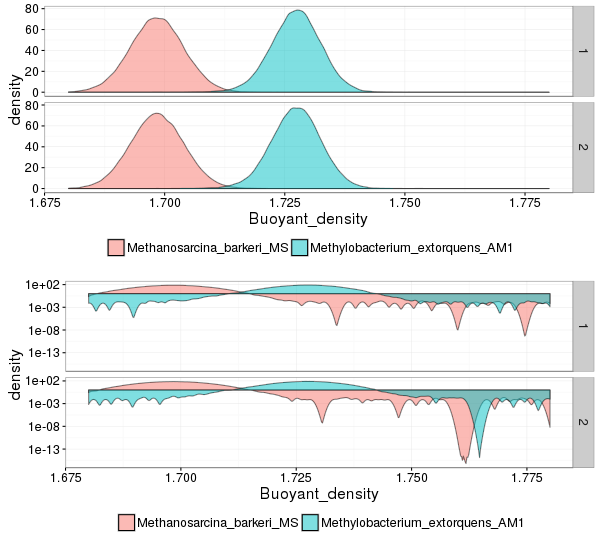

In [675]:
%%R -w 600 -h 550
df = read.delim('shotFrag_skewN90-25-n5-nS_dif_kde_DBL.txt', sep='\t') %>%
    gather(taxon, Buoyant_density, Methanosarcina_barkeri_MS, Methylobacterium_extorquens_AM1) 


p = ggplot(df, aes(Buoyant_density, fill=taxon)) +
    geom_density(alpha=0.5) +
    scale_x_continuous(limits=c(1.68, 1.78)) +
    scale_fill_discrete('') +
    facet_grid(libID ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )
pl = p + scale_y_log10()

grid.arrange(p, pl, ncol=1)

## Simulating isotope incorporation

In [676]:
# making config file
config = """
[1]
  # baseline: no incorp
  
  [[intraPopDist 1]]
  distribution = uniform

    [[[start]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0

    [[[end]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 0
        end = 0
        
[2]
  # half of taxa incorporate
  max_perc_taxa_incorp = 100
  
  [[intraPopDist 1]]
  distribution = uniform

    [[[start]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 100
        end = 100

    [[[end]]]

      [[[[interPopDist 1]]]]
        distribution = uniform
        start = 100
        end = 100 
"""

outfile = os.path.join(workDir, 'incorp.config')

outf = open(outfile, 'wb')
outf.write(config)
outf.close()

In [677]:
!SIPSim isotope_incorp \
    shotFrag_skewN90-25-n5-nS_dif_kde_DBL.pkl \
    incorp.config \
    --comm comm-n2-unif.txt \
    --np 2 \
    > shotFrag_skewN90-25-n5-nS_dif_kde_DBL_incorp.pkl 

Loading KDE object...
Processing library: 1
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS
Processing library: 2
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS
File written: BD-shift_stats.txt


### Plotting distributions

In [678]:
n=100000
!SIPSim KDE_sample -n $n shotFrag_skewN90-25-n5-nS_dif_kde_DBL_incorp.pkl \
    > shotFrag_skewN90-25-n5-nS_dif_kde_DBL_incorp.txt

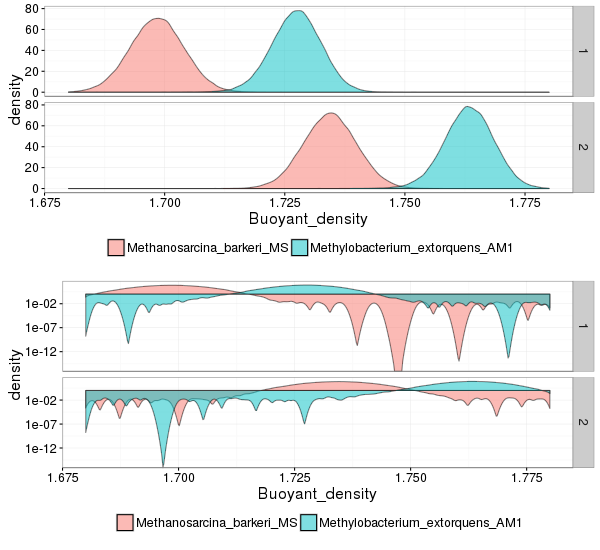

In [679]:
%%R -w 600 -h 550
df = read.delim('shotFrag_skewN90-25-n5-nS_dif_kde_DBL_incorp.txt', sep='\t') %>%
    gather(taxon, Buoyant_density, Methanosarcina_barkeri_MS, Methylobacterium_extorquens_AM1) 


p = ggplot(df, aes(Buoyant_density, fill=taxon)) +
    geom_density(alpha=0.5) +
    scale_x_continuous(limits=c(1.68, 1.78)) +
    scale_fill_discrete('') +
    facet_grid(libID ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )
pl = p + scale_y_log10()

grid.arrange(p, pl, ncol=1)

## Making OTU table

In [680]:
!SIPSim OTU_table \
    shotFrag_skewN90-25-n5-nS_dif_kde_DBL_incorp.pkl \
    comm-n2-unif.txt \
    fracs-n2-unif.txt \
    --abs 1e9 \
    --np 2 \
    > shotFrag_OTU_n2_abs1e9.txt
    
!head shotFrag_OTU_n2_abs1e9.txt

Loading files...
Simulating OTUs...
Processing library: "1"
  Processing taxon: "Methanosarcina_barkeri_MS"
   taxon abs-abundance:  1000000000
  Processing taxon: "Methylobacterium_extorquens_AM1"
   taxon abs-abundance:  0
Processing library: "2"
  Processing taxon: "Methanosarcina_barkeri_MS"
   taxon abs-abundance:  0
  Processing taxon: "Methylobacterium_extorquens_AM1"
   taxon abs-abundance:  1000000000
library	taxon	fraction	BD_min	BD_mid	BD_max	count	rel_abund
1	Methanosarcina_barkeri_MS	-inf-1.660	-inf	1.659	1.659	277962	1.0
1	Methanosarcina_barkeri_MS	1.660-1.662	1.66	1.661	1.662	16101	1.0
1	Methanosarcina_barkeri_MS	1.662-1.668	1.662	1.665	1.668	31705	1.0
1	Methanosarcina_barkeri_MS	1.668-1.676	1.668	1.672	1.676	181586	1.0
1	Methanosarcina_barkeri_MS	1.676-1.684	1.676	1.68	1.684	5520181	1.0
1	Methanosarcina_barkeri_MS	1.684-1.691	1.684	1.688	1.691	86848646	1.0
1	Methanosarcina_barkeri_MS	1.691-1.697	1.691	1.694	1.697	305690615	1.0
1	Methanosarcina_barkeri_MS	1.697-1.705	1.6

## Plotting OTU abundances

In [59]:
%%R -i workDir

# loading file
F = file.path(workDir, 'shotFrag_OTU_n2_abs1e9.txt')
df =  read.delim(F)

df1 = df %>%
    filter(library == 1,
           taxon == 'Methanosarcina_barkeri_MS')
df2 = df %>%
    filter(library == 2,
           taxon == 'Methylobacterium_extorquens_AM1')
df = rbind(df1, df2)

df.all = df %>% 
    group_by(library) %>%
    mutate(rel_abund = count / max(count)) %>%
    ungroup()
df.all %>% head(n=3) %>% as.data.frame

  library                     taxon    fraction BD_min BD_mid BD_max  count
1       1 Methanosarcina_barkeri_MS  -inf-1.660   -Inf  1.659  1.659 277962
2       1 Methanosarcina_barkeri_MS 1.660-1.662  1.660  1.661  1.662  16101
3       1 Methanosarcina_barkeri_MS 1.662-1.668  1.662  1.665  1.668  31705
     rel_abund
1 5.777657e-04
2 3.346718e-05
3 6.590131e-05


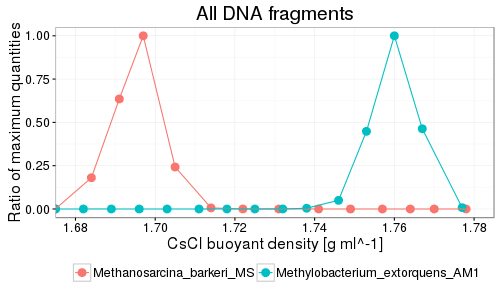

In [60]:
%%R -w 500 -h 300

# max possible shift for M barkeri (using mean G+C)
max_shift = 1.727326 + 0.036

# plotting
p.all = ggplot(df.all, aes(BD_min, rel_abund, color=taxon)) +
    geom_point(size=3.5) +
    geom_line() +
    #geom_vline(xintercept=c(1.698416, 1.727326), linetype='dashed', alpha=0.5) +
    #geom_vline(xintercept=c(max_shift), linetype='dashed', alpha=0.5, color='blue') +
    scale_x_continuous(limits=c(1.68, 1.78), breaks=seq(1.68, 1.78, 0.02)) +
    scale_color_discrete('') +
    labs(x='CsCl buoyant density [g ml^-1]', y='Ratio of maximum quantities', 
         title='All DNA fragments') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'bottom'
    )
p.all

***

# SIPSim of amplicon fragments

* for comparing to qPCR results

## Simulating fragments

In [136]:
# primers
primers = """>Ar109f
ACKGCTCAGTAACACGT
>Ar915r
GTGCTCCCCCGCCAATTCCT
>Ba519f
CAGCMGCCGCGGTAANWC
>Ba907r
CCGTCAATTCMTTTRAGTT
"""
primer_file = 'Ba-Ar_primers.fna'
with open(primer_file, 'wb') as outFH:
    outFH.write(primers)
    
!cat $primer_file

>Ar109f
ACKGCTCAGTAACACGT
>Ar915r
GTGCTCCCCCGCCAATTCCT
>Ba519f
CAGCMGCCGCGGTAANWC
>Ba907r
CCGTCAATTCMTTTRAGTT


In [137]:
!SIPSim fragments \
    genome_index.txt \
    --fp genomes_rn \
    --fr Ba-Ar_primers.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 2 \
    2> ampFrag_skewN90-25-n5-nS.log \
    > ampFrag_skewN90-25-n5-nS.pkl
    
!tail ampFrag_skewN90-25-n5-nS.log    

Processing: "Methanosarcina_barkeri_MS"
Processing: "Methylobacterium_extorquens_AM1"
  Genome name: Methanosarcina_barkeri_MS
  Genome name: Methylobacterium_extorquens_AM1
  Genome length (bp): 4533209
  Number of amplicons: 3
  Number of fragments simulated: 10000
  Genome length (bp): 5511322
  Number of amplicons: 5
  Number of fragments simulated: 10000


## Converting to 2d-kde objects

* Also converts fragment G+C to buoyant density

In [685]:
!SIPSim fragment_KDE \
    --bw $bandwidth \
    ampFrag_skewN90-25-n5-nS.pkl \
    > ampFrag_skewN90-25-n5-nS_kde.pkl

!ls -thlc ampFrag_skewN90-25-n5-nS_kde.pkl

-rw-rw-r-- 1 nick nick 315K Mar 18 09:27 ampFrag_skewN90-25-n5-nS_kde.pkl


### Plotting distributions

In [686]:
n=100000
!SIPSim KDE_sample -n $n ampFrag_skewN90-25-n5-nS_kde.pkl > ampFrag_skewN90-25-n5-nS_kde.txt

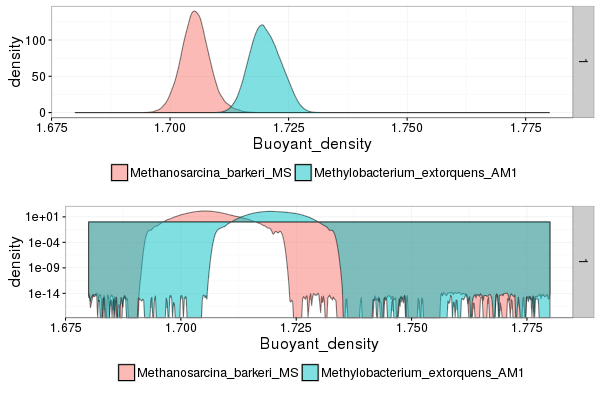

In [687]:
%%R -w 600 -h 400
df = read.delim('ampFrag_skewN90-25-n5-nS_kde.txt', sep='\t') %>%
    gather(taxon, Buoyant_density, Methanosarcina_barkeri_MS, Methylobacterium_extorquens_AM1) 


p = ggplot(df, aes(Buoyant_density, fill=taxon)) +
    geom_density(alpha=0.5) +
    scale_x_continuous(limits=c(1.68, 1.78)) +
    scale_fill_discrete('') +
    facet_grid(libID ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )
pl = p + scale_y_log10()

grid.arrange(p, pl, ncol=1)

## Adding diffusion

In [688]:
!SIPSim diffusion \
    --np 2 \
    --bw $bandwidth \
    ampFrag_skewN90-25-n5-nS_kde.pkl \
    > ampFrag_skewN90-25-n5-nS_dif_kde.pkl
    
!ls -thlc ampFrag_skewN90-25-n5-nS_dif_kde.pkl

Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS
-rw-rw-r-- 1 nick nick 7.7M Mar 18 09:27 ampFrag_skewN90-25-n5-nS_dif_kde.pkl


### Plotting distributions

In [689]:
n=100000
!SIPSim KDE_sample -n $n ampFrag_skewN90-25-n5-nS_kde.pkl > ampFrag_skewN90-25-n5-nS_kde.txt

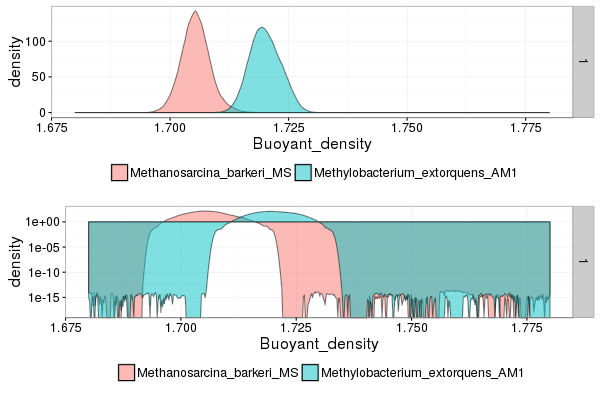

In [690]:
%%R -w 600 -h 400
df = read.delim('ampFrag_skewN90-25-n5-nS_kde.txt', sep='\t') %>%
    gather(taxon, Buoyant_density, Methanosarcina_barkeri_MS, Methylobacterium_extorquens_AM1) 


p = ggplot(df, aes(Buoyant_density, fill=taxon)) +
    geom_density(alpha=0.5) +
    scale_x_continuous(limits=c(1.68, 1.78)) +
    scale_fill_discrete('') +
    facet_grid(libID ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )
pl = p + scale_y_log10()

grid.arrange(p, pl, ncol=1)

## Adding DBL smearing

In [691]:
!SIPSim DBL \
    ampFrag_skewN90-25-n5-nS_dif_kde.pkl \
    --comm comm-n2-unif.txt \
    --commx 0 \
    -D 1.725 \
    -w 19807714 \
    --tube_height 5.1 \
    --r_min 7.47 \
    --r_max 8.79 \
    --vertical \
    --np 2 \
    > ampFrag_skewN90-25-n5-nS_dif_kde_DBL.pkl

DBL_index file written: "DBL_index.txt"
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS


### Plotting smearing index

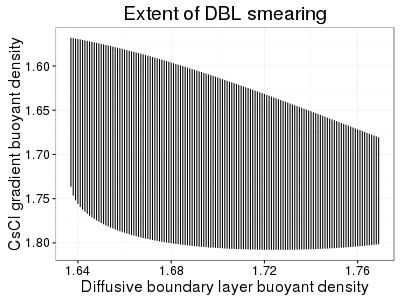

In [692]:
%%R -h 300 -w 400
df = read.delim('DBL_index.txt', sep='\t')

ggplot(df, aes(DBL_BD, ymin=vert_gradient_BD_low, ymax=vert_gradient_BD_high)) +
    geom_linerange() +
    scale_y_reverse() +
    labs(x='Diffusive boundary layer buoyant density', 
         y='CsCl gradient buoyant density',
         title='Extent of DBL smearing') +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

### Plotting distributions

In [693]:
n=100000
!SIPSim KDE_sample -n $n ampFrag_skewN90-25-n5-nS_kde.pkl > ampFrag_skewN90-25-n5-nS_kde.txt

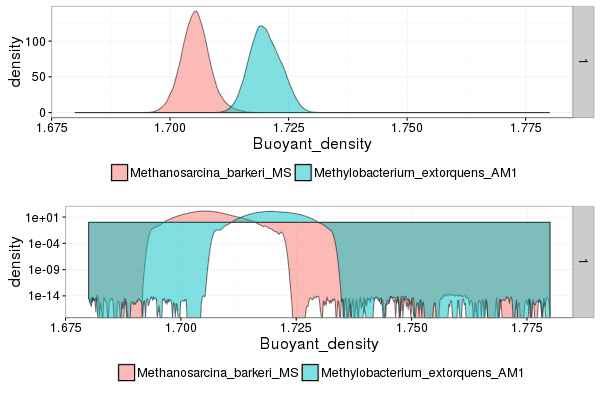

In [694]:
%%R -w 600 -h 400
df = read.delim('ampFrag_skewN90-25-n5-nS_kde.txt', sep='\t') %>%
    gather(taxon, Buoyant_density, Methanosarcina_barkeri_MS, Methylobacterium_extorquens_AM1) 


p = ggplot(df, aes(Buoyant_density, fill=taxon)) +
    geom_density(alpha=0.5) +
    scale_x_continuous(limits=c(1.68, 1.78)) +
    scale_fill_discrete('') +
    facet_grid(libID ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )
pl = p + scale_y_log10()

grid.arrange(p, pl, ncol=1)

## Simulating isotope incorporation

In [695]:
!SIPSim isotope_incorp \
    ampFrag_skewN90-25-n5-nS_dif_kde_DBL.pkl \
    incorp.config \
    --comm comm-n2-unif.txt \
    --np 2 \
    > ampFrag_skewN90-25-n5-nS_dif_kde_DBL_incorp.pkl 

Loading KDE object...
Processing library: 1
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS
Processing library: 2
Processing: Methylobacterium_extorquens_AM1
Processing: Methanosarcina_barkeri_MS
File written: BD-shift_stats.txt


### Plotting distributions

In [696]:
n=100000
!SIPSim KDE_sample -n $n ampFrag_skewN90-25-n5-nS_kde.pkl > ampFrag_skewN90-25-n5-nS_kde.txt

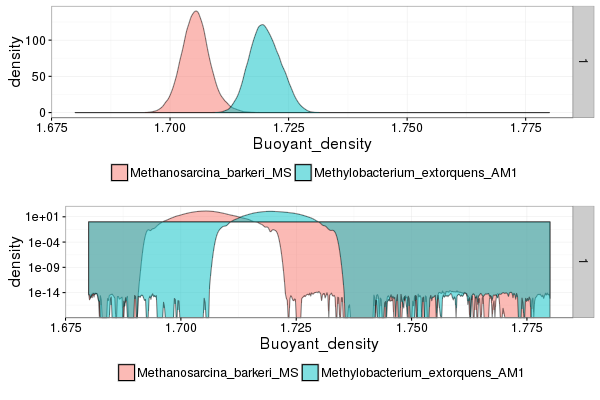

In [697]:
%%R -w 600 -h 400
df = read.delim('ampFrag_skewN90-25-n5-nS_kde.txt', sep='\t') %>%
    gather(taxon, Buoyant_density, Methanosarcina_barkeri_MS, Methylobacterium_extorquens_AM1) 


p = ggplot(df, aes(Buoyant_density, fill=taxon)) +
    geom_density(alpha=0.5) +
    scale_x_continuous(limits=c(1.68, 1.78)) +
    scale_fill_discrete('') +
    facet_grid(libID ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16),
        legend.position = 'bottom'
    )
pl = p + scale_y_log10()

grid.arrange(p, pl, ncol=1)

## Making OTU table

In [698]:
!SIPSim OTU_table \
    ampFrag_skewN90-25-n5-nS_dif_kde_DBL_incorp.pkl \
    comm-n2-unif.txt \
    fracs-n2-unif.txt \
    --abs 1e9 \
    --np 2 \
    > ampFrag_OTU_n2_abs1e9.txt
    
!head ampFrag_OTU_n2_abs1e9.txt

Loading files...
Simulating OTUs...
Processing library: "1"
  Processing taxon: "Methanosarcina_barkeri_MS"
   taxon abs-abundance:  1000000000
  Processing taxon: "Methylobacterium_extorquens_AM1"
   taxon abs-abundance:  0
Processing library: "2"
  Processing taxon: "Methanosarcina_barkeri_MS"
   taxon abs-abundance:  0
  Processing taxon: "Methylobacterium_extorquens_AM1"
   taxon abs-abundance:  1000000000
library	taxon	fraction	BD_min	BD_mid	BD_max	count	rel_abund
1	Methanosarcina_barkeri_MS	-inf-1.660	-inf	1.659	1.659	241572	1
1	Methanosarcina_barkeri_MS	1.660-1.662	1.66	1.661	1.662	16581	1
1	Methanosarcina_barkeri_MS	1.662-1.668	1.662	1.665	1.668	23103	1
1	Methanosarcina_barkeri_MS	1.668-1.676	1.668	1.672	1.676	45314	1
1	Methanosarcina_barkeri_MS	1.676-1.684	1.676	1.68	1.684	74948	1
1	Methanosarcina_barkeri_MS	1.684-1.691	1.684	1.688	1.691	2115284	1
1	Methanosarcina_barkeri_MS	1.691-1.697	1.691	1.694	1.697	44804032	1
1	Methanosarcina_barkeri_MS	1.697-1.705	1.697	1.701	1.705	4245

## Plotting OTU abundances

In [61]:
%%R -i workDir

# loading file
F = file.path(workDir, 'ampFrag_OTU_n2_abs1e9.txt')
df =  read.delim(F)

df1 = df %>%
    filter(library == 1,
           taxon == 'Methanosarcina_barkeri_MS')
df2 = df %>%
    filter(library == 2,
           taxon == 'Methylobacterium_extorquens_AM1')
df = rbind(df1, df2)

df.16S = df %>% 
    group_by(library) %>%
    mutate(rel_abund = count / max(count)) %>%
    ungroup()
df.16S %>% head(n=3) %>% as.data.frame

  library                     taxon    fraction BD_min BD_mid BD_max  count
1       1 Methanosarcina_barkeri_MS  -inf-1.660   -Inf  1.659  1.659 241572
2       1 Methanosarcina_barkeri_MS 1.660-1.662  1.660  1.661  1.662  16581
3       1 Methanosarcina_barkeri_MS 1.662-1.668  1.662  1.665  1.668  23103
     rel_abund
1 5.054602e-04
2 3.469374e-05
3 4.834024e-05


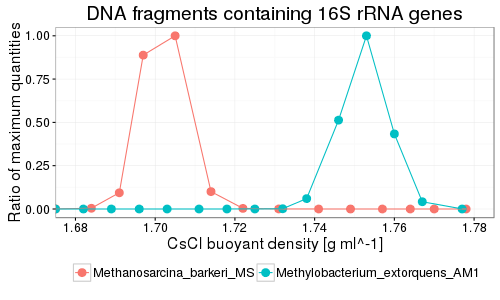

In [63]:
%%R -w 500 -h 300

# max possible shift for M barkeri (using mean G+C)
max_shift = 1.727326 + 0.036

# plotting
p.16S = ggplot(df.16S, aes(BD_min, rel_abund, color=taxon)) +
    geom_point(size=3.5) +
    geom_line() +
    #geom_vline(xintercept=c(1.698416, 1.727326), linetype='dashed', alpha=0.5) +
    #geom_vline(xintercept=c(max_shift), linetype='dashed', alpha=0.5, color='blue') +
    scale_x_continuous(limits=c(1.68, 1.78), breaks=seq(1.68, 1.78, 0.02)) +
    scale_color_discrete('') +
    labs(x='CsCl buoyant density [g ml^-1]', y='Ratio of maximum quantities', 
         title='DNA fragments containing 16S rRNA genes') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        legend.position = 'bottom'
    )
p.16S

# Plotting with Lueders

## Lueders 2004, figure 1

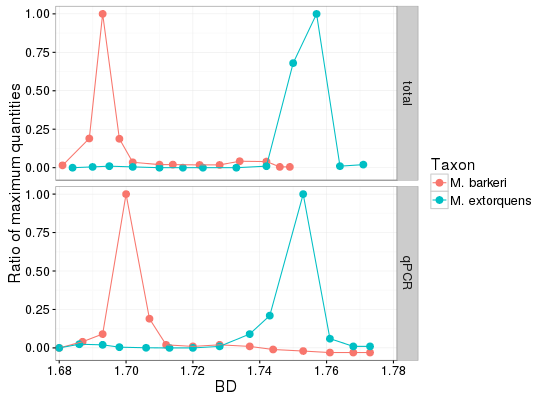

In [38]:
%%R -i workDir -i lueders_fig1 -w 550 -h 400

# loading data
df.lueders = gdata::read.xls(lueders_fig1)
df.lueders$DNA = factor(df.lueders$DNA, levels=c('total', 'qPCR'))

# plotting
ggplot(df.lueders, aes(BD, conc, color=Taxon)) +
    geom_point(size=3) +
    geom_line() +
    scale_x_continuous(limits=c(1.68, 1.78), 
                       breaks=seq(1.68, 1.78, 0.02), 
                       expand=c(0.001,0.001)) +
    labs(y='Ratio of maximum quantities') +
    facet_grid(DNA ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )

## Combining data

In [110]:
%%R
# simulation data
tmp1 = df.all %>% 
    dplyr::select(taxon, BD_min, count) %>%
    mutate(DNA = 'Total DNA')

tmp2 = df.16S %>% 
    dplyr::select(taxon, BD_min, count) %>%
    mutate(DNA = '16S rRNA genes')

df.j = rbind(tmp1, tmp2) %>%
    group_by(taxon, DNA) %>%
    mutate(rel_abund = count / max(count)) %>%
    ungroup() %>%
    mutate(taxon = gsub('Methanosarcina_barkeri_MS', 'M. barkeri MS', taxon),
           taxon = gsub('Methylobacterium_extorquens_AM1', 'M. extorquens AM1', taxon)) %>%
    dplyr::select(-count) %>%
    mutate(dataset='simulation')
colnames(df.j) = c('Taxon', 'BD', 'DNA', 'conc', 'dataset')
tmp1 = tmp2 = NULL

# status
df.j %>% tail(n=3)

Source: local data frame [3 x 5]

              Taxon    BD            DNA         conc    dataset
              (chr) (dbl)          (chr)        (dbl)      (chr)
1 M. extorquens AM1 1.785 16S rRNA genes 0.0000601645 simulation
2 M. extorquens AM1 1.792 16S rRNA genes 0.0000726349 simulation
3 M. extorquens AM1 1.801 16S rRNA genes 0.0004804151 simulation


In [116]:
%%R
df.lueders.f = df.lueders %>%
    mutate(DNA = gsub('total', 'Total DNA', DNA),
           DNA = gsub('qPCR', '16S rRNA genes', DNA),
           Taxon = gsub('M. barkeri', 'M. barkeri MS', Taxon),
           Taxon = gsub('M. extorquens', 'M. extorquens AM1', Taxon)) %>%
    mutate(dataset='Lueders et al. 2004')


df.j.j = rbind(df.j, df.lueders.f)
df.j.j %>% head(n=3)

Source: local data frame [3 x 5]

          Taxon    BD       DNA         conc    dataset
          (chr) (dbl)     (chr)        (dbl)      (chr)
1 M. barkeri MS  -Inf Total DNA 5.777657e-04 simulation
2 M. barkeri MS 1.660 Total DNA 3.346718e-05 simulation
3 M. barkeri MS 1.662 Total DNA 6.590131e-05 simulation


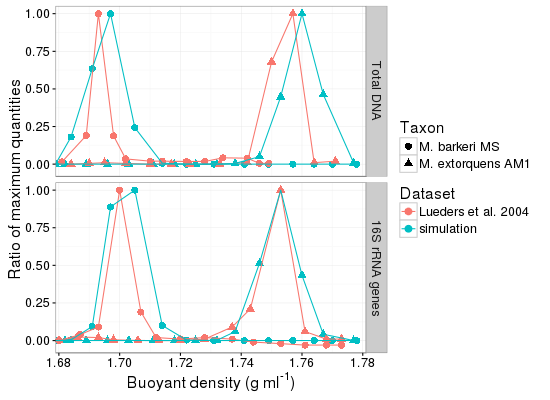

In [213]:
%%R -w 550 -h 400

df.j.j$DNA = factor(df.j.j$DNA, levels=c('Total DNA', '16S rRNA genes'))

x.lab = expression(paste('Buoyant density (g ml' ^ '-1', ')'))

# plotting
p = ggplot(df.j.j, aes(BD, conc, color=dataset, shape=Taxon)) +
    geom_point(size=3) +
    geom_line() +
    scale_color_discrete('Dataset') +
    scale_x_continuous(limits=c(1.68, 1.78), 
                       breaks=seq(1.68, 1.78, 0.02), 
                       expand=c(0.001,0.001)) +
    labs(x=x.lab, y='Ratio of maximum quantities') +
    facet_grid(DNA ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )
p

In [214]:
%%R -i workDir
# saving
F = file.path(workDir, 'Lueders2004_validate.pdf')
ggsave(F, p, width=8, height=5.8)
cat('File written:', F, '\n')

File written: /home/nick/notebook/SIPSim/dev/Leuders2004//Lueders2004_validate.pdf 


### Linear interpolation of BDs

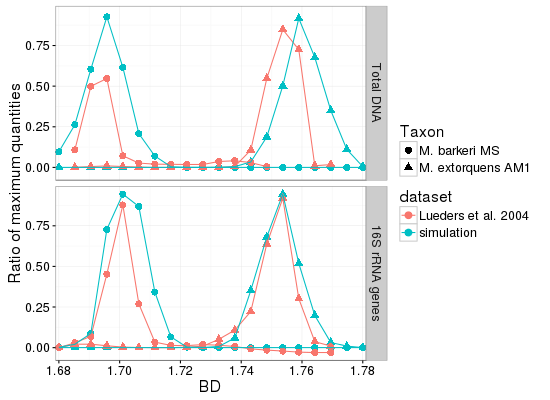

In [136]:
%%R -w 550 -h 400
# linear interpolation of conc for an evenly distributed set of BDs

#approxfun
BDs = seq(1.68, 1.78, (1.78-1.68)/19)

interp = function(df, BDs){
    F = approxfun(df$BD, df$conc)
    x = data.frame('BD' = BDs,
                   'conc_interp' = F(BDs))
    return(x)
}

df.j.j.int = df.j.j %>%
    group_by(dataset, Taxon, DNA) %>%
    nest() %>%
    mutate(conc_interp_df = lapply(data, interp, BDs=BDs)) %>%
    unnest(conc_interp = conc_interp_df %>% purrr::map(function(x) x)) %>%
    ungroup()
 

# plotting check
ggplot(df.j.j.int, aes(BD, conc_interp, color=dataset, shape=Taxon)) +
    geom_point(size=3) +
    geom_line() +
    scale_x_continuous(limits=c(1.68, 1.78), 
                       breaks=seq(1.68, 1.78, 0.02), 
                       expand=c(0.001,0.001)) +
    labs(y='Ratio of maximum quantities') +
    facet_grid(DNA ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )       

### correlation coef

In [155]:
%%R
# reformat
df.sim = df.j.j.int %>%
    filter(!is.na(conc_interp),
           dataset=='simulation')
df.L = df.j.j.int %>%
    filter(!is.na(conc_interp),
           dataset=='Lueders et al. 2004')
 
df.c = inner_join(df.sim, df.L, c('Taxon'='Taxon',
                                  'BD'='BD',
                                  'DNA'='DNA'))
# status
df.c %>% head(n=3)   

Source: local data frame [3 x 7]

   dataset.x         Taxon       DNA       BD conc_interp.x           dataset.y
       (chr)         (chr)    (fctr)    (dbl)         (dbl)               (chr)
1 simulation M. barkeri MS Total DNA 1.685263     0.2626053 Lueders et al. 2004
2 simulation M. barkeri MS Total DNA 1.690526     0.6046204 Lueders et al. 2004
3 simulation M. barkeri MS Total DNA 1.695789     0.9264407 Lueders et al. 2004
Variables not shown: conc_interp.y (dbl)


In [182]:
%%R
calc.pearson = function(x){
    xx = x[,'conc_interp.x'] %>% as.matrix %>% as.vector 
    xy = x[,'conc_interp.y'] %>% as.matrix %>% as.vector
    res = cor.test(xx, xy, method='pearson')
    df = data.frame('estimate' = c(res$estimate), 
                    'p.value' = c(res$p.value))
    return(df)
}


df.c.res = df.c %>%
    group_by(Taxon, DNA) %>%
    nest() %>%
    mutate(model = purrr::map(data, calc.pearson)) %>%
    unnest(pearson = model %>% purrr::map(function(x) x)) %>%
    dplyr::select(-data, -model)

# stats        
df.c.res

Source: local data frame [4 x 4]

              Taxon            DNA  estimate      p.value
              (chr)         (fctr)     (dbl)        (dbl)
1     M. barkeri MS      Total DNA 0.8522273 2.157861e-04
2 M. extorquens AM1      Total DNA 0.6698756 3.261524e-03
3     M. barkeri MS 16S rRNA genes 0.8877369 8.870630e-07
4 M. extorquens AM1 16S rRNA genes 0.9696783 3.266907e-11


### Difference in modes btw total & 16S

* did the simulation accurately show the conservation of G+C (BD) relative to total gDNA?

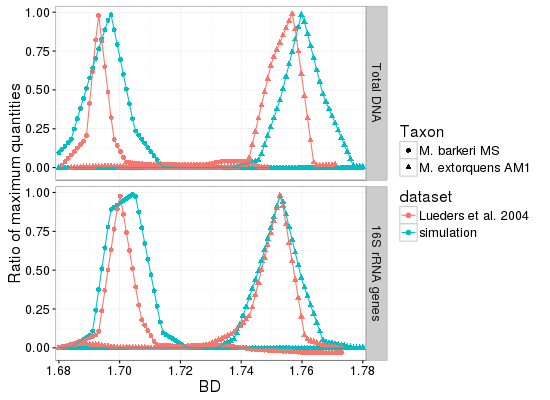

In [203]:
%%R -w 550 -h 400
# linear interpolation of conc for an evenly distributed set of BDs

#approxfun
BDs = seq(1.68, 1.78, (1.78-1.68)/99)

interp = function(df, BDs){
    F = approxfun(df$BD, df$conc)
    x = data.frame('BD' = BDs,
                   'conc_interp' = F(BDs))
    return(x)
}

df.j.j.int = df.j.j %>%
    group_by(dataset, Taxon, DNA) %>%
    nest() %>%
    mutate(conc_interp_df = lapply(data, interp, BDs=BDs)) %>%
    unnest(conc_interp = conc_interp_df %>% purrr::map(function(x) x)) %>%
    ungroup()
 
        
# plotting check
ggplot(df.j.j.int, aes(BD, conc_interp, color=dataset, shape=Taxon)) +
    geom_point(size=2) +
    geom_line() +
    scale_x_continuous(limits=c(1.68, 1.78), 
                       breaks=seq(1.68, 1.78, 0.02), 
                       expand=c(0.001,0.001)) +
    labs(y='Ratio of maximum quantities') +
    facet_grid(DNA ~ .) +
    theme_bw() +
    theme(
        text = element_text(size=16)
    )         

In [206]:
%%R
# determining locations of the modes
df.j.j.int.f = df.j.j.int %>%
    group_by(dataset, Taxon, DNA) %>%
    mutate(max_conc = max(conc_interp, na.rm=TRUE)) %>%
    ungroup() %>%
    filter(conc_interp == max_conc) %>%
    dplyr::select(dataset, Taxon, BD, DNA) %>%
    mutate(DNA = gsub(' ', '_', DNA),
           DNA = gsub('16', 'X16', DNA)) %>%
    spread(DNA, BD) %>%
    mutate(BD_shift = round(abs(Total_DNA - X16S_rRNA_genes), 3))

# BD shift of mode between Total DNA * 16S amplcons
df.j.j.int.f 

Source: local data frame [4 x 5]

              dataset             Taxon Total_DNA X16S_rRNA_genes BD_shift
                (chr)             (chr)     (dbl)           (dbl)    (dbl)
1 Lueders et al. 2004     M. barkeri MS  1.693131        1.700202    0.007
2 Lueders et al. 2004 M. extorquens AM1  1.756768        1.752727    0.004
3          simulation     M. barkeri MS  1.697172        1.704242    0.007
4          simulation M. extorquens AM1  1.759798        1.752727    0.007
